## LSTM Measuring

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Simulation 1: Variogram 0.2

## No scale: Y value 0

In [9]:
# 
training_set = pd.read_csv('datasets/orig_v1_0.csv')
training_set

,x,y,Phi
0,0.0,0.0,0.108549
1,100.0,0.0,0.120677
2,200.0,0.0,0.109326
3,300.0,0.0,0.100903
4,400.0,0.0,0.094381
...,...,...,...
95,9500.0,0.0,0.148605
96,9600.0,0.0,0.031793
97,9700.0,0.0,0.081810
98,9800.0,0.0,0.109246


In [10]:
training_set = training_set.iloc[:,2:3].values
# training_set

In [11]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [12]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, p):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.p = p
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [17]:
num_epochs = 2000
learning_rate = 0.1

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values=[]
loss_test_values=[]
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_values.append(loss.item())
    # obtain the loss function
    
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04491
Epoch: 100, loss: 0.04151
Epoch: 200, loss: 0.03986
Epoch: 300, loss: 0.02932
Epoch: 400, loss: 0.02215
Epoch: 500, loss: 0.01917
Epoch: 600, loss: 0.02125
Epoch: 700, loss: 0.01657
Epoch: 800, loss: 0.01629
Epoch: 900, loss: 0.01621
Epoch: 1000, loss: 0.01606
Epoch: 1100, loss: 0.01520
Epoch: 1200, loss: 0.01484
Epoch: 1300, loss: 0.01459
Epoch: 1400, loss: 0.01516
Epoch: 1500, loss: 0.01438
Epoch: 1600, loss: 0.01388
Epoch: 1700, loss: 0.01406
Epoch: 1800, loss: 0.01456
Epoch: 1900, loss: 0.01356


Text(0, 0.5, 'Loss')

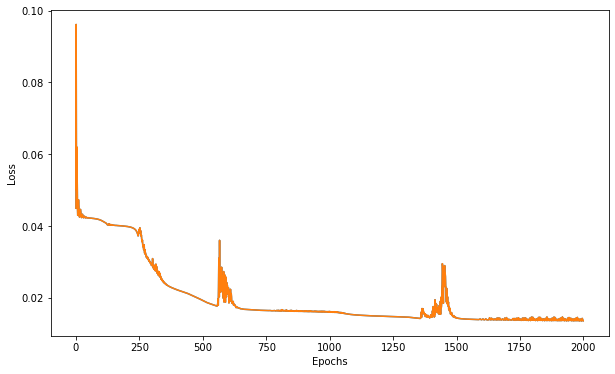

In [18]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

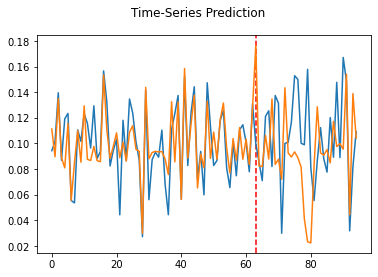

In [19]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [20]:
training_set = pd.read_csv('datasets/orig_v1_100.csv')
training_set

,x,y,Phi
0,0.0,100.0,0.102697
1,100.0,100.0,0.097253
2,200.0,100.0,0.108343
3,300.0,100.0,0.080838
4,400.0,100.0,0.113272
...,...,...,...
95,9500.0,100.0,0.054091
96,9600.0,100.0,0.067456
97,9700.0,100.0,0.110254
98,9800.0,100.0,0.069066


In [21]:
training_set = training_set.iloc[:,2:3].values

In [22]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [23]:
num_epochs = 2000
learning_rate = 0.02

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
p = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.23544
Epoch: 100, loss: 0.04441
Epoch: 200, loss: 0.04386
Epoch: 300, loss: 0.04370
Epoch: 400, loss: 0.04367
Epoch: 500, loss: 0.04365
Epoch: 600, loss: 0.04362
Epoch: 700, loss: 0.04355
Epoch: 800, loss: 0.04338
Epoch: 900, loss: 0.04277
Epoch: 1000, loss: 0.03708
Epoch: 1100, loss: 0.03383
Epoch: 1200, loss: 0.03087
Epoch: 1300, loss: 0.02552
Epoch: 1400, loss: 0.02265
Epoch: 1500, loss: 0.02113
Epoch: 1600, loss: 0.02049
Epoch: 1700, loss: 0.02005
Epoch: 1800, loss: 0.01911
Epoch: 1900, loss: 0.01791


Text(0, 0.5, 'Loss')

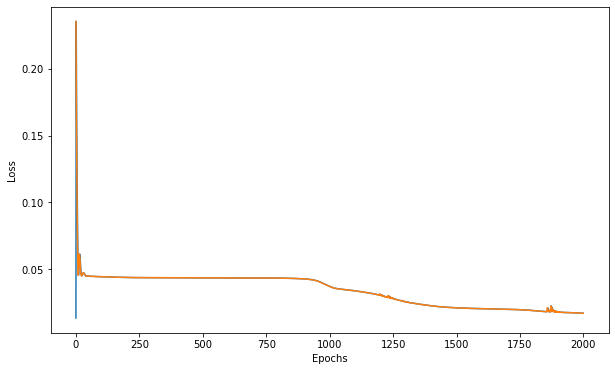

In [24]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

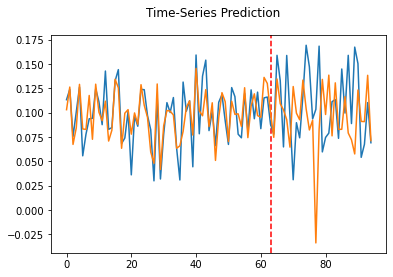

In [25]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [38]:
training_set = pd.read_csv('datasets/orig_v1_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [39]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.05#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01475
Epoch: 100, loss: 0.01390
Epoch: 200, loss: 0.01389
Epoch: 300, loss: 0.01386
Epoch: 400, loss: 0.01289
Epoch: 500, loss: 0.01106
Epoch: 600, loss: 0.01084
Epoch: 700, loss: 0.01068
Epoch: 800, loss: 0.01031
Epoch: 900, loss: 0.01164
Epoch: 1000, loss: 0.00886
Epoch: 1100, loss: 0.00854
Epoch: 1200, loss: 0.00808
Epoch: 1300, loss: 0.00788
Epoch: 1400, loss: 0.00777
Epoch: 1500, loss: 0.00769
Epoch: 1600, loss: 0.00768
Epoch: 1700, loss: 0.00757
Epoch: 1800, loss: 0.00749
Epoch: 1900, loss: 0.00741


Text(0, 0.5, 'Loss')

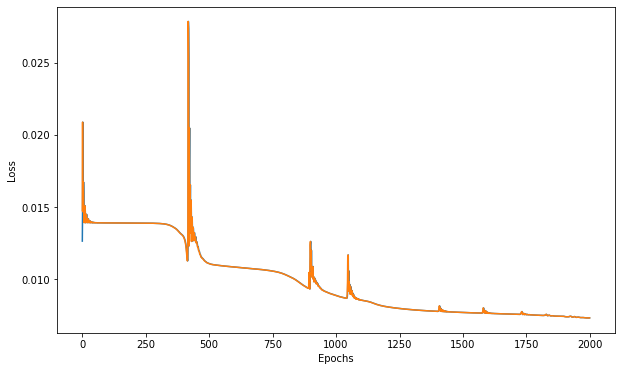

In [40]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

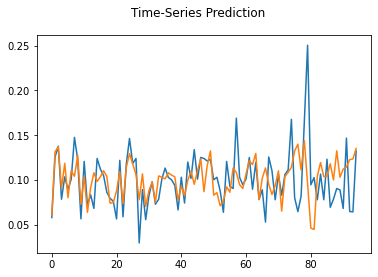

In [41]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [42]:
training_set = pd.read_csv('datasets/orig_v1_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [43]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.33604
Epoch: 100, loss: 0.05204
Epoch: 200, loss: 0.05199
Epoch: 300, loss: 0.05177
Epoch: 400, loss: 0.05036
Epoch: 500, loss: 0.04906
Epoch: 600, loss: 0.04843
Epoch: 700, loss: 0.04788
Epoch: 800, loss: 0.04747
Epoch: 900, loss: 0.04694
Epoch: 1000, loss: 0.04007
Epoch: 1100, loss: 0.03461
Epoch: 1200, loss: 0.02767
Epoch: 1300, loss: 0.02365
Epoch: 1400, loss: 0.02302
Epoch: 1500, loss: 0.02183
Epoch: 1600, loss: 0.02105
Epoch: 1700, loss: 0.02042
Epoch: 1800, loss: 0.02262
Epoch: 1900, loss: 0.01951


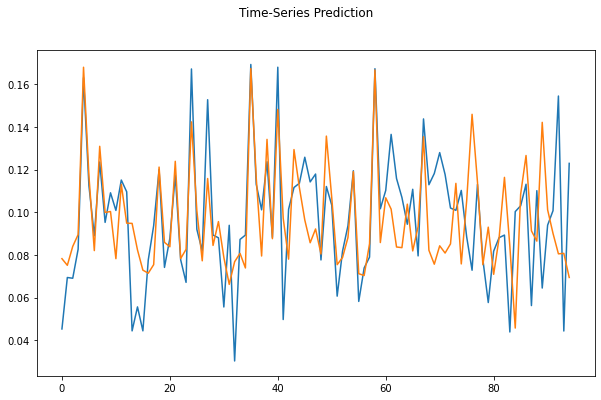

In [44]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [45]:
training_set = pd.read_csv('datasets/orig_v1_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [46]:
num_epochs = 2500 #1000 epochs
learning_rate = 0.08#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14749
Epoch: 100, loss: 0.02259
Epoch: 200, loss: 0.02246
Epoch: 300, loss: 0.02226
Epoch: 400, loss: 0.02174
Epoch: 500, loss: 0.02106
Epoch: 600, loss: 0.02073
Epoch: 700, loss: 0.02024
Epoch: 800, loss: 0.01995
Epoch: 900, loss: 0.01885
Epoch: 1000, loss: 0.01821
Epoch: 1100, loss: 0.01746
Epoch: 1200, loss: 0.01716
Epoch: 1300, loss: 0.01700
Epoch: 1400, loss: 0.01664
Epoch: 1500, loss: 0.01630
Epoch: 1600, loss: 0.01583
Epoch: 1700, loss: 0.01549
Epoch: 1800, loss: 0.02393
Epoch: 1900, loss: 0.01455
Epoch: 2000, loss: 0.01438
Epoch: 2100, loss: 0.01420
Epoch: 2200, loss: 0.01401
Epoch: 2300, loss: 0.01382
Epoch: 2400, loss: 0.01356


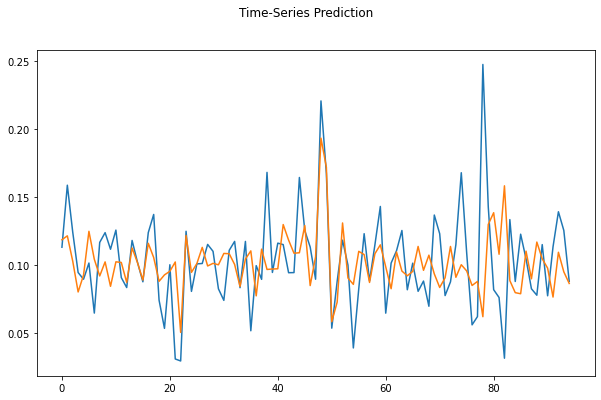

In [47]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.2, Scaled by 50

In [48]:
training_set = pd.read_csv('datasets/scaled_v1_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [49]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.69708
Epoch: 100, loss: 0.03487
Epoch: 200, loss: 0.03481
Epoch: 300, loss: 0.03478
Epoch: 400, loss: 0.03474
Epoch: 500, loss: 0.03456
Epoch: 600, loss: 0.03056
Epoch: 700, loss: 0.01282
Epoch: 800, loss: 0.01178
Epoch: 900, loss: 0.01008
Epoch: 1000, loss: 0.00763
Epoch: 1100, loss: 0.00638
Epoch: 1200, loss: 0.00582
Epoch: 1300, loss: 0.00530
Epoch: 1400, loss: 0.00495
Epoch: 1500, loss: 0.00466
Epoch: 1600, loss: 0.00435
Epoch: 1700, loss: 0.00408
Epoch: 1800, loss: 0.00391
Epoch: 1900, loss: 0.00378


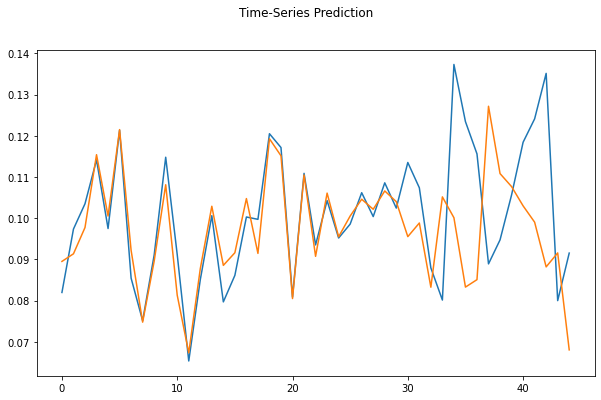

In [50]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [51]:
training_set = pd.read_csv('datasets/scaled_v1_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [58]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.7

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.21248
Epoch: 100, loss: 0.05969
Epoch: 200, loss: 0.05360
Epoch: 300, loss: 0.04774
Epoch: 400, loss: 0.03919
Epoch: 500, loss: 0.03443
Epoch: 600, loss: 0.02645
Epoch: 700, loss: 0.02090
Epoch: 800, loss: 0.01884
Epoch: 900, loss: 0.01739
Epoch: 1000, loss: 0.01491
Epoch: 1100, loss: 0.01112
Epoch: 1200, loss: 0.00911
Epoch: 1300, loss: 0.00798
Epoch: 1400, loss: 0.00760
Epoch: 1500, loss: 0.00736
Epoch: 1600, loss: 0.00691
Epoch: 1700, loss: 0.00649
Epoch: 1800, loss: 0.00484
Epoch: 1900, loss: 0.00413


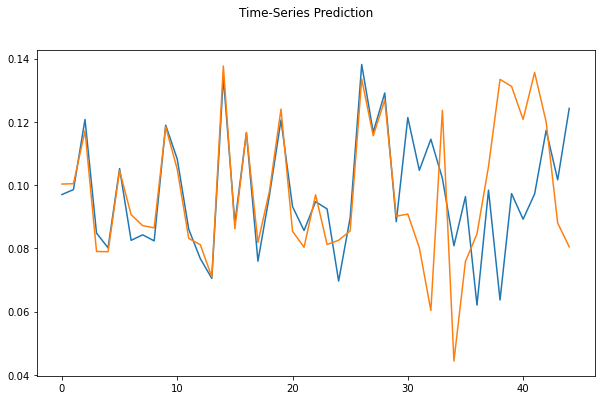

In [59]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [60]:
training_set = pd.read_csv('datasets/scaled_v1_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [61]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.03#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.09779
Epoch: 100, loss: 0.06063
Epoch: 200, loss: 0.06052
Epoch: 300, loss: 0.06043
Epoch: 400, loss: 0.06024
Epoch: 500, loss: 0.05892
Epoch: 600, loss: 0.05174
Epoch: 700, loss: 0.04631
Epoch: 800, loss: 0.04209
Epoch: 900, loss: 0.03959
Epoch: 1000, loss: 0.03903
Epoch: 1100, loss: 0.03868
Epoch: 1200, loss: 0.03848
Epoch: 1300, loss: 0.03831
Epoch: 1400, loss: 0.03812
Epoch: 1500, loss: 0.03784
Epoch: 1600, loss: 0.03716
Epoch: 1700, loss: 0.03644
Epoch: 1800, loss: 0.03210
Epoch: 1900, loss: 0.02550


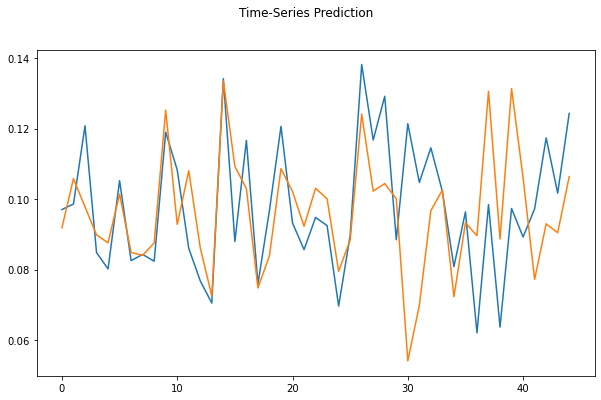

In [62]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [64]:
training_set = pd.read_csv('datasets/scaled_v1_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [67]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.20223
Epoch: 100, loss: 0.03056
Epoch: 200, loss: 0.03033
Epoch: 300, loss: 0.03002
Epoch: 400, loss: 0.02983
Epoch: 500, loss: 0.02928
Epoch: 600, loss: 0.02886
Epoch: 700, loss: 0.02738
Epoch: 800, loss: 0.01941
Epoch: 900, loss: 0.01293
Epoch: 1000, loss: 0.01004
Epoch: 1100, loss: 0.00800
Epoch: 1200, loss: 0.00771
Epoch: 1300, loss: 0.00677
Epoch: 1400, loss: 0.00687
Epoch: 1500, loss: 0.00636
Epoch: 1600, loss: 0.00620
Epoch: 1700, loss: 0.00647
Epoch: 1800, loss: 0.00625
Epoch: 1900, loss: 0.00600


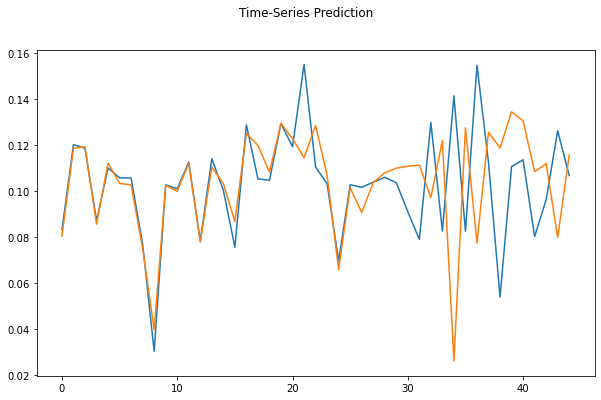

In [68]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [69]:
training_set = pd.read_csv('datasets/scaled_v1_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [74]:
num_epochs = 500 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.47612
Epoch: 100, loss: 0.03156
Epoch: 200, loss: 0.02183
Epoch: 300, loss: 0.00593
Epoch: 400, loss: 0.00267


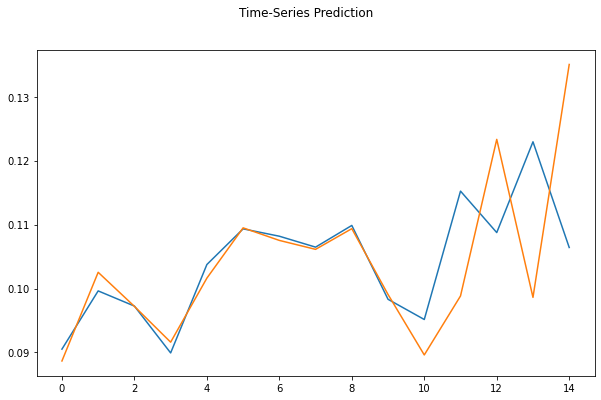

In [76]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [86]:
training_set = pd.read_csv('datasets/scaled_v1_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 600 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04112
Epoch: 100, loss: 0.02159
Epoch: 200, loss: 0.00556
Epoch: 300, loss: 0.00028
Epoch: 400, loss: 0.00037
Epoch: 500, loss: 0.00003


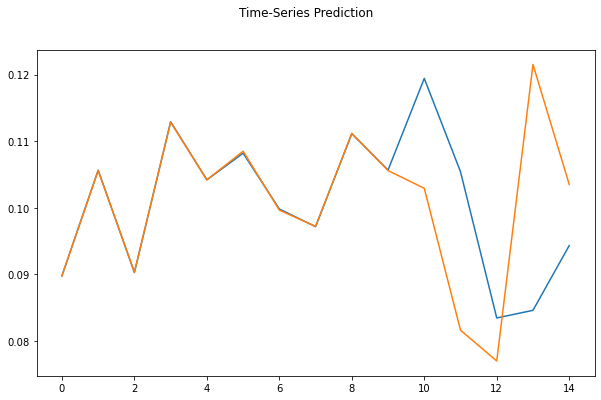

In [87]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [93]:
training_set = pd.read_csv('datasets/scaled_v1_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 600 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11756
Epoch: 100, loss: 0.00621
Epoch: 200, loss: 0.00062
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00007


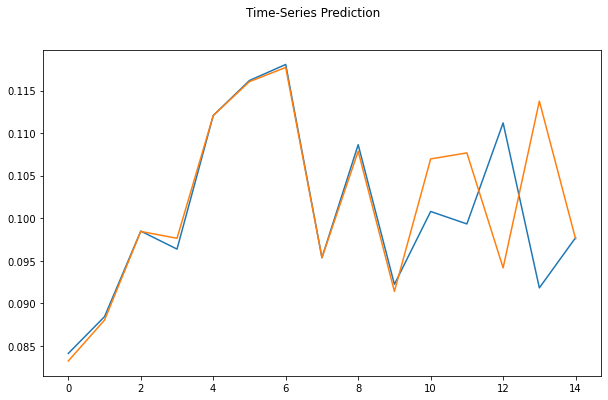

In [94]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [103]:
training_set = pd.read_csv('datasets/scaled_v1_10_495.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 980 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.61308
Epoch: 100, loss: 0.02423
Epoch: 200, loss: 0.02208
Epoch: 300, loss: 0.01921
Epoch: 400, loss: 0.00037
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000


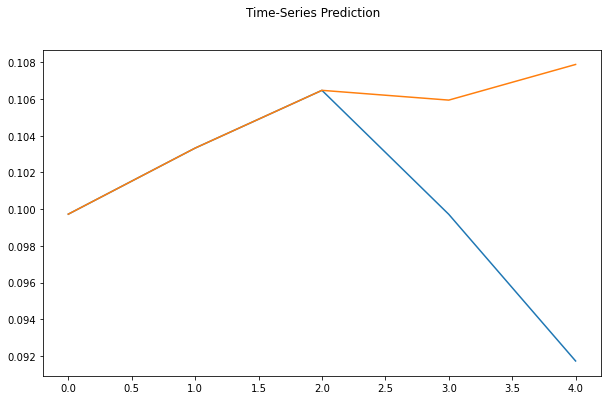

In [104]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.26863
Epoch: 100, loss: 0.00002


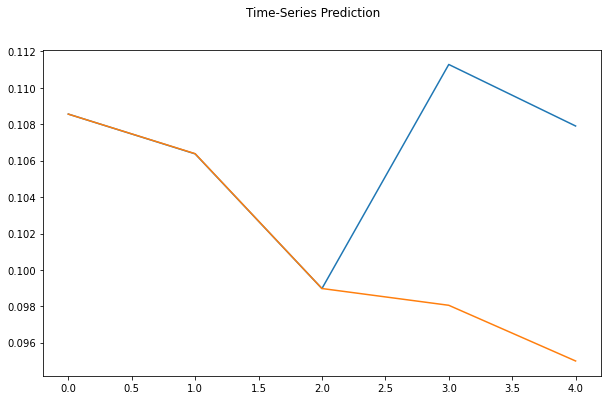

In [111]:
training_set = pd.read_csv('datasets/scaled_v1_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.56376
Epoch: 100, loss: 0.00001


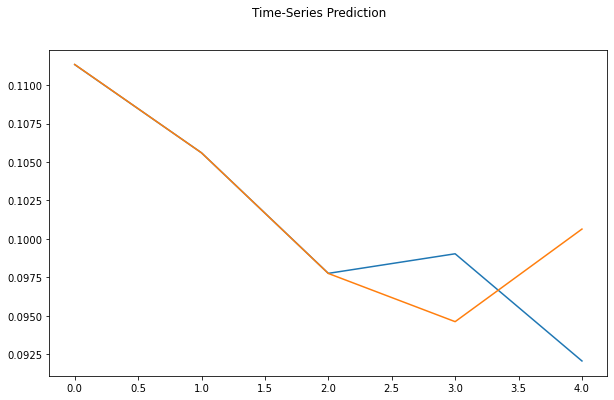

In [116]:
training_set = pd.read_csv('datasets/scaled_v1_10_970.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.09#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.4

Epoch: 0, loss: 0.06007
Epoch: 100, loss: 0.00139


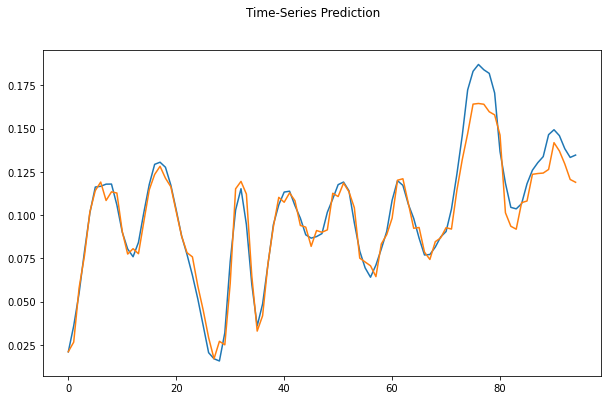

In [118]:
training_set = pd.read_csv('datasets/orig_sim2_0.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04674
Epoch: 100, loss: 0.00105


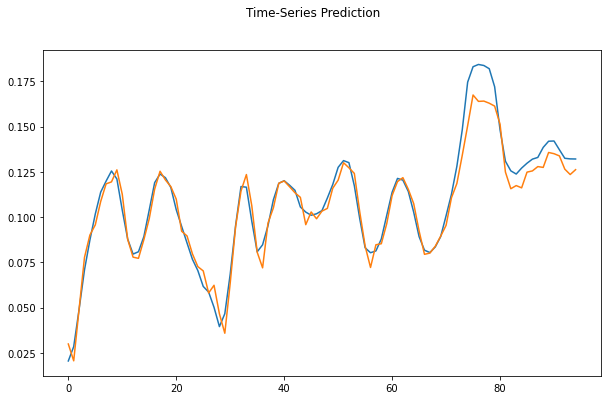

In [119]:
training_set = pd.read_csv('datasets/orig_sim2_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.15090
Epoch: 100, loss: 0.00192


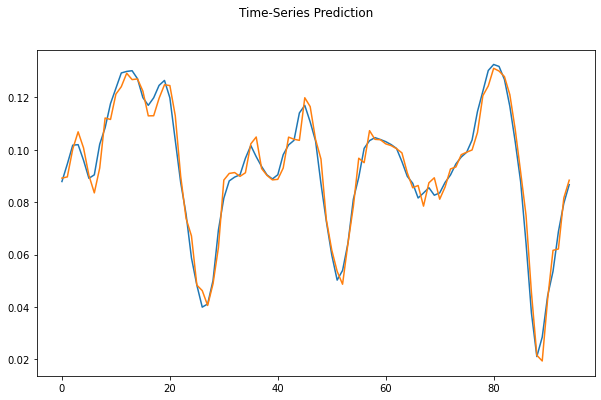

In [121]:
training_set = pd.read_csv('datasets/orig_sim2_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 200 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.06252
Epoch: 100, loss: 0.00160


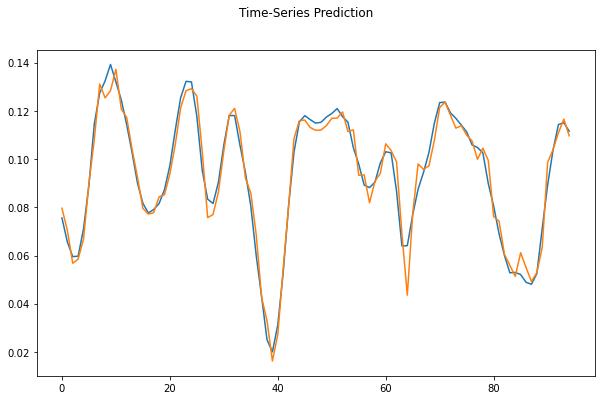

In [122]:
training_set = pd.read_csv('datasets/orig_sim2_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.51621
Epoch: 100, loss: 0.00250


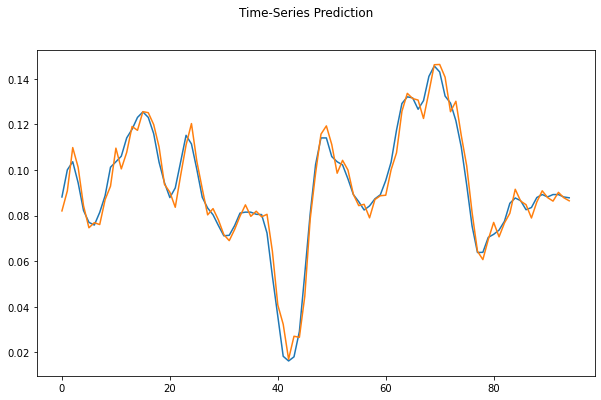

In [124]:
training_set = pd.read_csv('datasets/orig_sim2_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 200 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.5

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.06428
Epoch: 100, loss: 0.00867
Epoch: 200, loss: 0.00609
Epoch: 300, loss: 0.00490
Epoch: 400, loss: 0.00463
Epoch: 500, loss: 0.00404
Epoch: 600, loss: 0.00365
Epoch: 700, loss: 0.00309
Epoch: 800, loss: 0.00289
Epoch: 900, loss: 0.00261
Epoch: 1000, loss: 0.00229
Epoch: 1100, loss: 0.00206
Epoch: 1200, loss: 0.00193
Epoch: 1300, loss: 0.00185
Epoch: 1400, loss: 0.00181
Epoch: 1500, loss: 0.00168
Epoch: 1600, loss: 0.00166
Epoch: 1700, loss: 0.00164
Epoch: 1800, loss: 0.00155
Epoch: 1900, loss: 0.00155


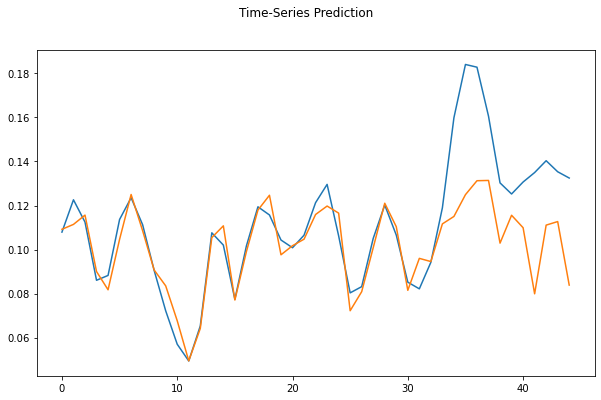

In [133]:
training_set = pd.read_csv('datasets/scaled_v2_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.45057
Epoch: 100, loss: 0.03134
Epoch: 200, loss: 0.02850
Epoch: 300, loss: 0.02426
Epoch: 400, loss: 0.00708
Epoch: 500, loss: 0.00536
Epoch: 600, loss: 0.00411
Epoch: 700, loss: 0.00343
Epoch: 800, loss: 0.00319
Epoch: 900, loss: 0.00305
Epoch: 1000, loss: 0.00291
Epoch: 1100, loss: 0.00277
Epoch: 1200, loss: 0.00263
Epoch: 1300, loss: 0.00250
Epoch: 1400, loss: 0.00239
Epoch: 1500, loss: 0.00231
Epoch: 1600, loss: 0.00224
Epoch: 1700, loss: 0.00218
Epoch: 1800, loss: 0.00210
Epoch: 1900, loss: 0.00203


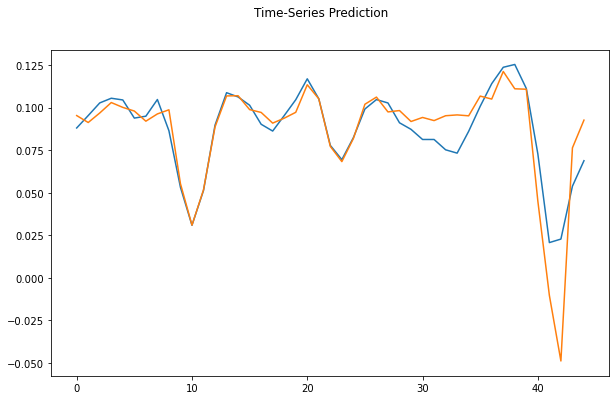

In [137]:
training_set = pd.read_csv('datasets/scaled_v2_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.10248
Epoch: 100, loss: 0.00796
Epoch: 200, loss: 0.00396
Epoch: 300, loss: 0.00174
Epoch: 400, loss: 0.00150
Epoch: 500, loss: 0.00188
Epoch: 600, loss: 0.00193
Epoch: 700, loss: 0.00112
Epoch: 800, loss: 0.00107
Epoch: 900, loss: 0.00104
Epoch: 1000, loss: 0.00100
Epoch: 1100, loss: 0.00097
Epoch: 1200, loss: 0.00106
Epoch: 1300, loss: 0.00089
Epoch: 1400, loss: 0.00083
Epoch: 1500, loss: 0.00084
Epoch: 1600, loss: 0.00074
Epoch: 1700, loss: 0.00070
Epoch: 1800, loss: 0.00068
Epoch: 1900, loss: 0.00065


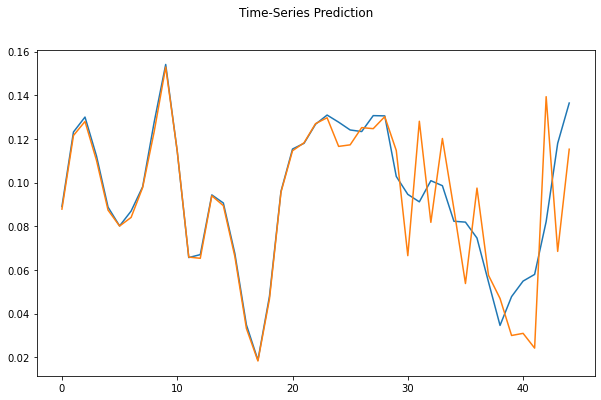

In [142]:
training_set = pd.read_csv('datasets/scaled_v2_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.65651
Epoch: 100, loss: 0.01215
Epoch: 200, loss: 0.01104
Epoch: 300, loss: 0.00927
Epoch: 400, loss: 0.00857
Epoch: 500, loss: 0.00811
Epoch: 600, loss: 0.00746
Epoch: 700, loss: 0.00644
Epoch: 800, loss: 0.00616
Epoch: 900, loss: 0.00577


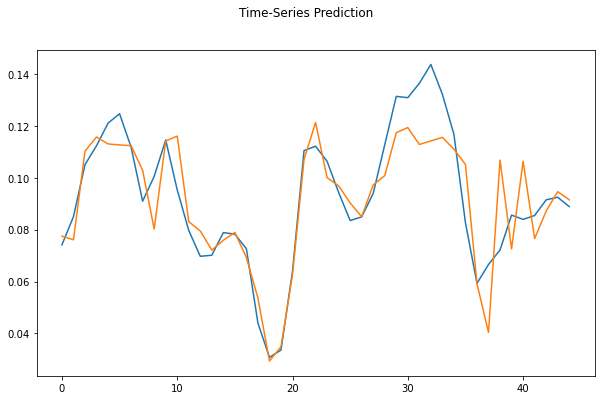

In [151]:
training_set = pd.read_csv('datasets/scaled_v2_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.08#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.02171
Epoch: 100, loss: 0.01041
Epoch: 200, loss: 0.00252
Epoch: 300, loss: 0.00213
Epoch: 400, loss: 0.00158
Epoch: 500, loss: 0.00133
Epoch: 600, loss: 0.00105
Epoch: 700, loss: 0.00050
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00000


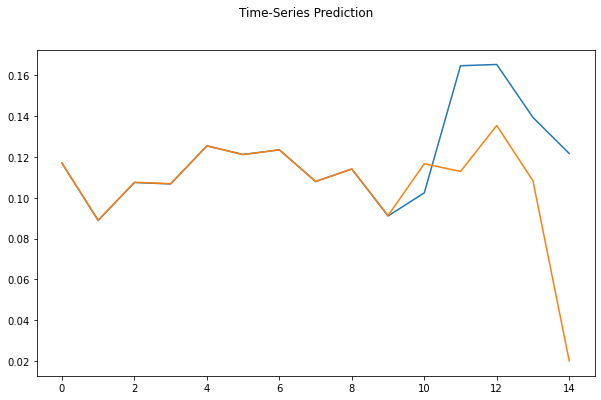

In [154]:
training_set = pd.read_csv('datasets/scaled_v2_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.64932
Epoch: 100, loss: 0.03363
Epoch: 200, loss: 0.03359
Epoch: 300, loss: 0.03242
Epoch: 400, loss: 0.01369
Epoch: 500, loss: 0.01215
Epoch: 600, loss: 0.00804
Epoch: 700, loss: 0.00202
Epoch: 800, loss: 0.00125
Epoch: 900, loss: 0.00003
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00003
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00010
Epoch: 1700, loss: 0.00000
Epoch: 1800, loss: 0.00006
Epoch: 1900, loss: 0.00001


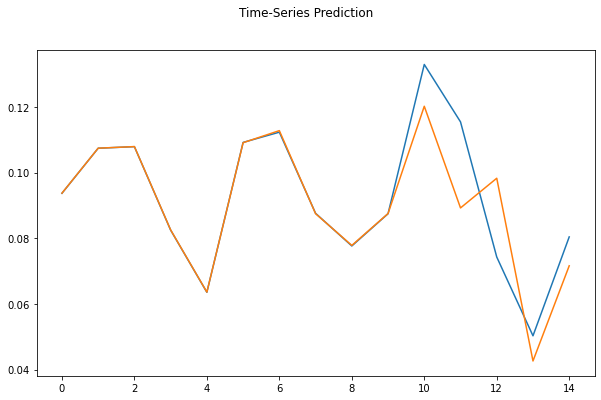

In [155]:
training_set = pd.read_csv('datasets/scaled_v2_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.21252
Epoch: 100, loss: 0.02153
Epoch: 200, loss: 0.01443
Epoch: 300, loss: 0.00133
Epoch: 400, loss: 0.00006
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00014
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00010
Epoch: 900, loss: 0.00010
Epoch: 1000, loss: 0.00100
Epoch: 1100, loss: 0.00006
Epoch: 1200, loss: 0.00003
Epoch: 1300, loss: 0.00006
Epoch: 1400, loss: 0.00006
Epoch: 1500, loss: 0.00009
Epoch: 1600, loss: 0.00016
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00002


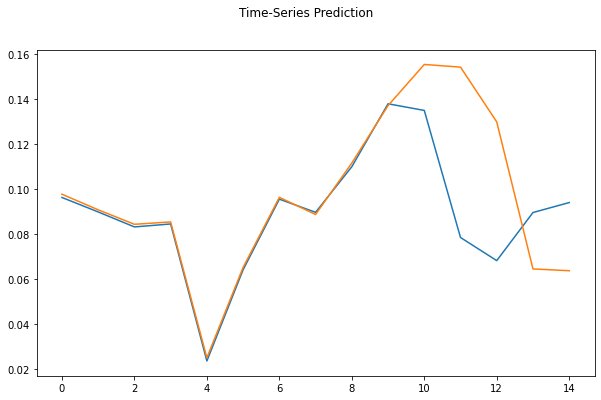

In [156]:
training_set = pd.read_csv('datasets/scaled_v2_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.87602
Epoch: 100, loss: 0.03478
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000


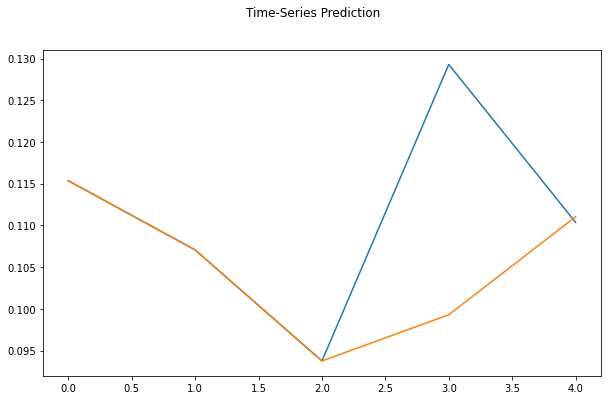

In [180]:
training_set = pd.read_csv('datasets/scaled_v2_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.05 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.84793
Epoch: 100, loss: 0.00137
Epoch: 200, loss: 0.00101
Epoch: 300, loss: 0.00097
Epoch: 400, loss: 0.00092
Epoch: 500, loss: 0.00087
Epoch: 600, loss: 0.00083
Epoch: 700, loss: 0.00079
Epoch: 800, loss: 0.00075
Epoch: 900, loss: 0.00071


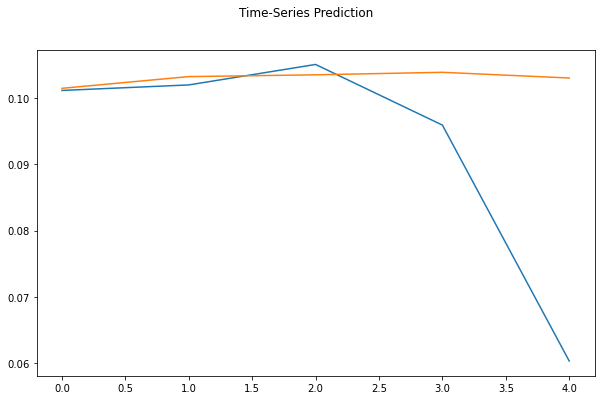

In [182]:
training_set = pd.read_csv('datasets/scaled_v2_10_495.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.9

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.20723


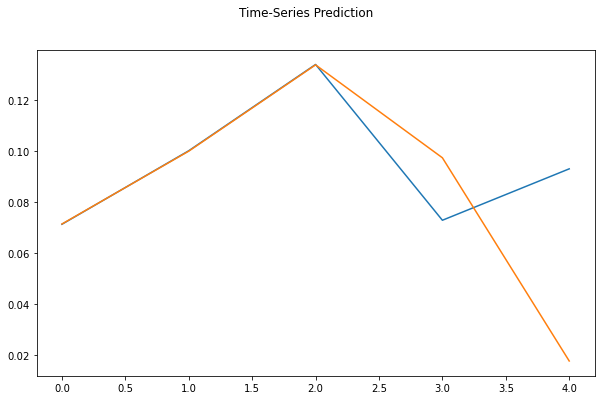

In [183]:
training_set = pd.read_csv('datasets/scaled_v2_10_970.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 100 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.6

Epoch: 0, loss: 0.21601
Epoch: 100, loss: 0.00272
Epoch: 200, loss: 0.00070
Epoch: 300, loss: 0.00064
Epoch: 400, loss: 0.00060
Epoch: 500, loss: 0.00056
Epoch: 600, loss: 0.00054
Epoch: 700, loss: 0.00052
Epoch: 800, loss: 0.00054
Epoch: 900, loss: 0.00049
Epoch: 1000, loss: 0.00048
Epoch: 1100, loss: 0.00047
Epoch: 1200, loss: 0.00047
Epoch: 1300, loss: 0.00046
Epoch: 1400, loss: 0.00045
Epoch: 1500, loss: 0.00044
Epoch: 1600, loss: 0.00042
Epoch: 1700, loss: 0.00040
Epoch: 1800, loss: 0.00041
Epoch: 1900, loss: 0.00046


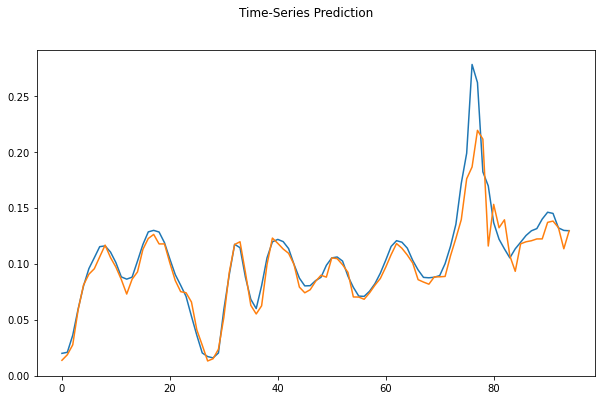

In [195]:
training_set = pd.read_csv('datasets/orig_sim3_0.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.23887
Epoch: 100, loss: 0.01520
Epoch: 200, loss: 0.00098
Epoch: 300, loss: 0.00078
Epoch: 400, loss: 0.00063
Epoch: 500, loss: 0.00058
Epoch: 600, loss: 0.00055
Epoch: 700, loss: 0.00053
Epoch: 800, loss: 0.00051
Epoch: 900, loss: 0.00049
Epoch: 1000, loss: 0.00045
Epoch: 1100, loss: 0.00041
Epoch: 1200, loss: 0.00037
Epoch: 1300, loss: 0.00038
Epoch: 1400, loss: 0.00036
Epoch: 1500, loss: 0.00035
Epoch: 1600, loss: 0.00034
Epoch: 1700, loss: 0.00033
Epoch: 1800, loss: 0.00034
Epoch: 1900, loss: 0.00032


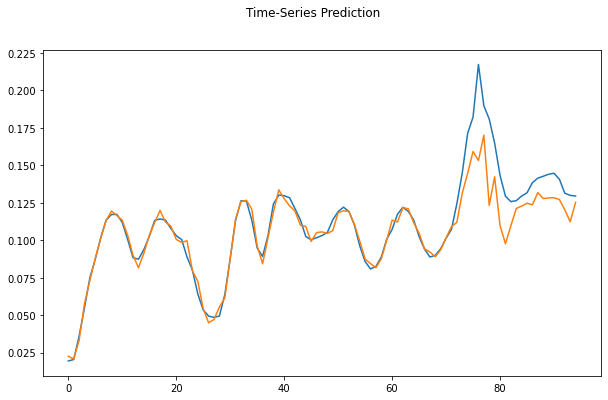

In [196]:
training_set = pd.read_csv('datasets/orig_sim3_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.14031
Epoch: 100, loss: 0.00533
Epoch: 200, loss: 0.00300
Epoch: 300, loss: 0.00184
Epoch: 400, loss: 0.00141
Epoch: 500, loss: 0.00141
Epoch: 600, loss: 0.00140
Epoch: 700, loss: 0.00140
Epoch: 800, loss: 0.00140
Epoch: 900, loss: 0.00139
Epoch: 1000, loss: 0.00139
Epoch: 1100, loss: 0.00140
Epoch: 1200, loss: 0.00139
Epoch: 1300, loss: 0.00147
Epoch: 1400, loss: 0.00139
Epoch: 1500, loss: 0.00139
Epoch: 1600, loss: 0.00139
Epoch: 1700, loss: 0.00139
Epoch: 1800, loss: 0.00140
Epoch: 1900, loss: 0.00139


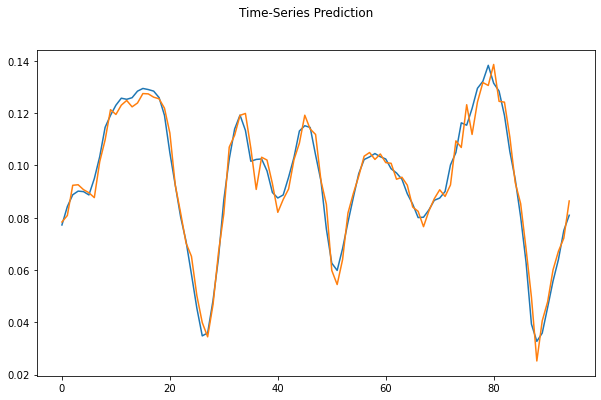

In [197]:
training_set = pd.read_csv('datasets/orig_sim3_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.37527
Epoch: 100, loss: 0.00376
Epoch: 200, loss: 0.00319
Epoch: 300, loss: 0.00285
Epoch: 400, loss: 0.00211
Epoch: 500, loss: 0.00158
Epoch: 600, loss: 0.00154
Epoch: 700, loss: 0.00144
Epoch: 800, loss: 0.00143
Epoch: 900, loss: 0.00135
Epoch: 1000, loss: 0.00132
Epoch: 1100, loss: 0.00130
Epoch: 1200, loss: 0.00176
Epoch: 1300, loss: 0.00126
Epoch: 1400, loss: 0.00125
Epoch: 1500, loss: 0.00124
Epoch: 1600, loss: 0.00129
Epoch: 1700, loss: 0.00127
Epoch: 1800, loss: 0.00122
Epoch: 1900, loss: 0.00124


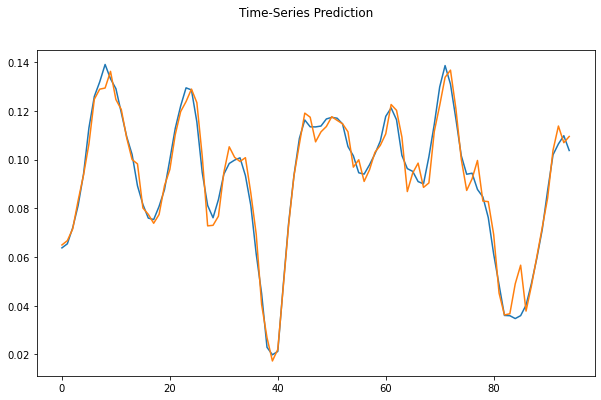

In [198]:
training_set = pd.read_csv('datasets/orig_sim3_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.03158
Epoch: 100, loss: 0.00208
Epoch: 200, loss: 0.00182
Epoch: 300, loss: 0.00132
Epoch: 400, loss: 0.00126
Epoch: 500, loss: 0.00122
Epoch: 600, loss: 0.00124
Epoch: 700, loss: 0.00117
Epoch: 800, loss: 0.00116
Epoch: 900, loss: 0.00116
Epoch: 1000, loss: 0.00115
Epoch: 1100, loss: 0.00151
Epoch: 1200, loss: 0.00114
Epoch: 1300, loss: 0.00114
Epoch: 1400, loss: 0.00180
Epoch: 1500, loss: 0.00113
Epoch: 1600, loss: 0.00113
Epoch: 1700, loss: 0.00114
Epoch: 1800, loss: 0.00112
Epoch: 1900, loss: 0.00112


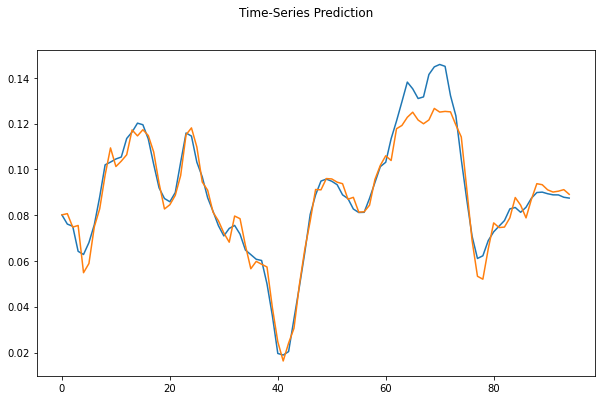

In [199]:
training_set = pd.read_csv('datasets/orig_sim3_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.05034
Epoch: 100, loss: 0.00846
Epoch: 200, loss: 0.00334
Epoch: 300, loss: 0.00288
Epoch: 400, loss: 0.00248
Epoch: 500, loss: 0.00096
Epoch: 600, loss: 0.00095
Epoch: 700, loss: 0.00057
Epoch: 800, loss: 0.00056
Epoch: 900, loss: 0.00054
Epoch: 1000, loss: 0.00054
Epoch: 1100, loss: 0.00054
Epoch: 1200, loss: 0.00053
Epoch: 1300, loss: 0.00052
Epoch: 1400, loss: 0.00051
Epoch: 1500, loss: 0.00051
Epoch: 1600, loss: 0.00053
Epoch: 1700, loss: 0.00050
Epoch: 1800, loss: 0.00049
Epoch: 1900, loss: 0.00048


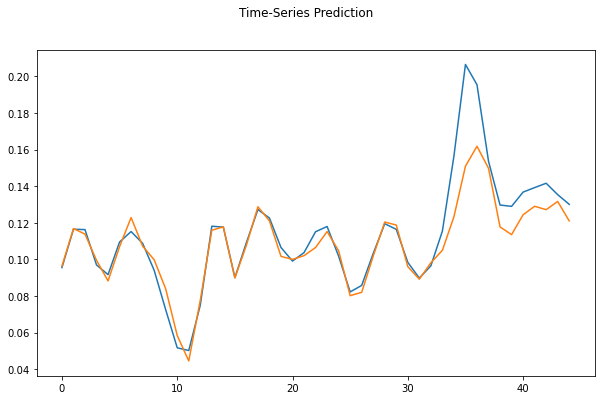

In [200]:
training_set = pd.read_csv('datasets/scaled_v3_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.09759
Epoch: 100, loss: 0.00744
Epoch: 200, loss: 0.00691
Epoch: 300, loss: 0.00652
Epoch: 400, loss: 0.00593
Epoch: 500, loss: 0.00574
Epoch: 600, loss: 0.00563
Epoch: 700, loss: 0.00553
Epoch: 800, loss: 0.00541
Epoch: 900, loss: 0.00527
Epoch: 1000, loss: 0.00511
Epoch: 1100, loss: 0.00491
Epoch: 1200, loss: 0.00469
Epoch: 1300, loss: 0.00449
Epoch: 1400, loss: 0.00426
Epoch: 1500, loss: 0.00397
Epoch: 1600, loss: 0.00348
Epoch: 1700, loss: 0.00278
Epoch: 1800, loss: 0.00218
Epoch: 1900, loss: 0.00198


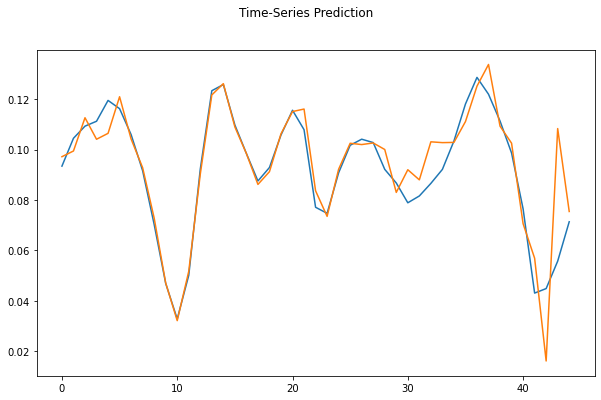

In [201]:
training_set = pd.read_csv('datasets/scaled_v3_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.99981
Epoch: 100, loss: 0.04240
Epoch: 200, loss: 0.02197
Epoch: 300, loss: 0.01233
Epoch: 400, loss: 0.00577
Epoch: 500, loss: 0.00544
Epoch: 600, loss: 0.00500
Epoch: 700, loss: 0.00454
Epoch: 800, loss: 0.00429
Epoch: 900, loss: 0.00409
Epoch: 1000, loss: 0.00387
Epoch: 1100, loss: 0.00349
Epoch: 1200, loss: 0.00282
Epoch: 1300, loss: 0.00220
Epoch: 1400, loss: 0.00195
Epoch: 1500, loss: 0.00180
Epoch: 1600, loss: 0.00164
Epoch: 1700, loss: 0.00138
Epoch: 1800, loss: 0.00110
Epoch: 1900, loss: 0.00091


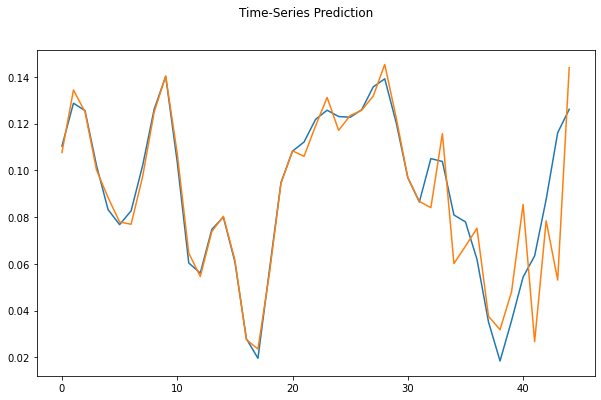

In [202]:
training_set = pd.read_csv('datasets/scaled_v3_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.27176
Epoch: 100, loss: 0.03559
Epoch: 200, loss: 0.01500
Epoch: 300, loss: 0.00709
Epoch: 400, loss: 0.00636
Epoch: 500, loss: 0.00582
Epoch: 600, loss: 0.00567
Epoch: 700, loss: 0.00555
Epoch: 800, loss: 0.00547
Epoch: 900, loss: 0.00542
Epoch: 1000, loss: 0.00537
Epoch: 1100, loss: 0.00532
Epoch: 1200, loss: 0.00527
Epoch: 1300, loss: 0.00522
Epoch: 1400, loss: 0.00518
Epoch: 1500, loss: 0.00513
Epoch: 1600, loss: 0.00509
Epoch: 1700, loss: 0.00505
Epoch: 1800, loss: 0.00499
Epoch: 1900, loss: 0.00493


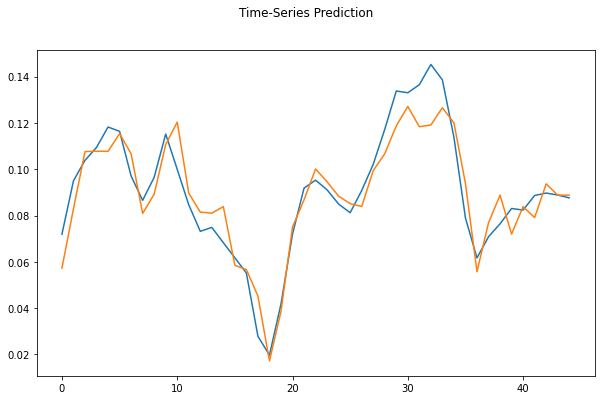

In [208]:
training_set = pd.read_csv('datasets/scaled_v3_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.18163
Epoch: 100, loss: 0.00709
Epoch: 200, loss: 0.00696
Epoch: 300, loss: 0.00696
Epoch: 400, loss: 0.00695
Epoch: 500, loss: 0.00695
Epoch: 600, loss: 0.00694
Epoch: 700, loss: 0.00693
Epoch: 800, loss: 0.00693
Epoch: 900, loss: 0.00692
Epoch: 1000, loss: 0.00691
Epoch: 1100, loss: 0.00691
Epoch: 1200, loss: 0.00690
Epoch: 1300, loss: 0.00689
Epoch: 1400, loss: 0.00689
Epoch: 1500, loss: 0.00688
Epoch: 1600, loss: 0.00687
Epoch: 1700, loss: 0.00686
Epoch: 1800, loss: 0.00686
Epoch: 1900, loss: 0.00685
Epoch: 2000, loss: 0.00683
Epoch: 2100, loss: 0.00682
Epoch: 2200, loss: 0.00680
Epoch: 2300, loss: 0.00678
Epoch: 2400, loss: 0.00674
Epoch: 2500, loss: 0.00668
Epoch: 2600, loss: 0.00657
Epoch: 2700, loss: 0.00635
Epoch: 2800, loss: 0.00584
Epoch: 2900, loss: 0.00464
Epoch: 3000, loss: 0.00279
Epoch: 3100, loss: 0.00146
Epoch: 3200, loss: 0.00121
Epoch: 3300, loss: 0.00103
Epoch: 3400, loss: 0.00090
Epoch: 3500, loss: 0.00082
Epoch: 3600, loss: 0.00077
Epoch: 3700, 

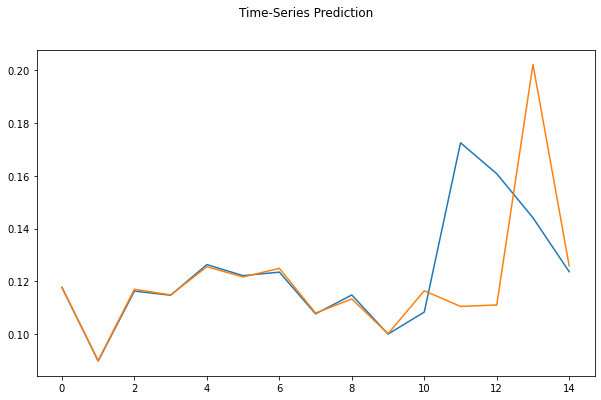

In [216]:
training_set = pd.read_csv('datasets/scaled_v3_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 6500 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.72506
Epoch: 100, loss: 0.01971
Epoch: 200, loss: 0.01966
Epoch: 300, loss: 0.01962
Epoch: 400, loss: 0.01954
Epoch: 500, loss: 0.01935
Epoch: 600, loss: 0.01887
Epoch: 700, loss: 0.01781
Epoch: 800, loss: 0.01615
Epoch: 900, loss: 0.01475
Epoch: 1000, loss: 0.01382
Epoch: 1100, loss: 0.01294
Epoch: 1200, loss: 0.01196
Epoch: 1300, loss: 0.01080
Epoch: 1400, loss: 0.00932
Epoch: 1500, loss: 0.00778
Epoch: 1600, loss: 0.00657
Epoch: 1700, loss: 0.00586
Epoch: 1800, loss: 0.00537
Epoch: 1900, loss: 0.00499


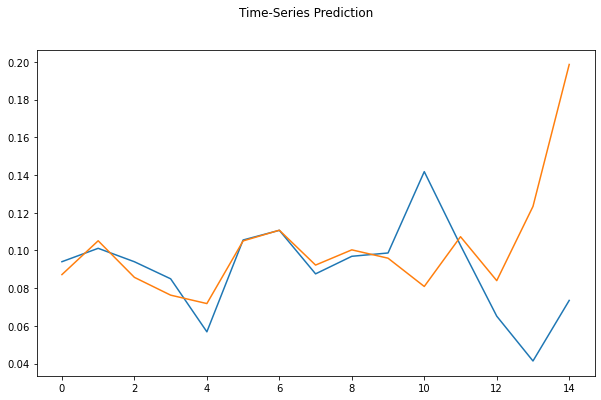

In [219]:
training_set = pd.read_csv('datasets/scaled_v3_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.05#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.65833
Epoch: 100, loss: 0.06544
Epoch: 200, loss: 0.06518
Epoch: 300, loss: 0.04769
Epoch: 400, loss: 0.01445
Epoch: 500, loss: 0.00970
Epoch: 600, loss: 0.00716
Epoch: 700, loss: 0.00610
Epoch: 800, loss: 0.00204
Epoch: 900, loss: 0.00175
Epoch: 1000, loss: 0.00148
Epoch: 1100, loss: 0.00121
Epoch: 1200, loss: 0.00089
Epoch: 1300, loss: 0.00024
Epoch: 1400, loss: 0.00006
Epoch: 1500, loss: 0.00005
Epoch: 1600, loss: 0.00007
Epoch: 1700, loss: 0.00006
Epoch: 1800, loss: 0.00003
Epoch: 1900, loss: 0.00003


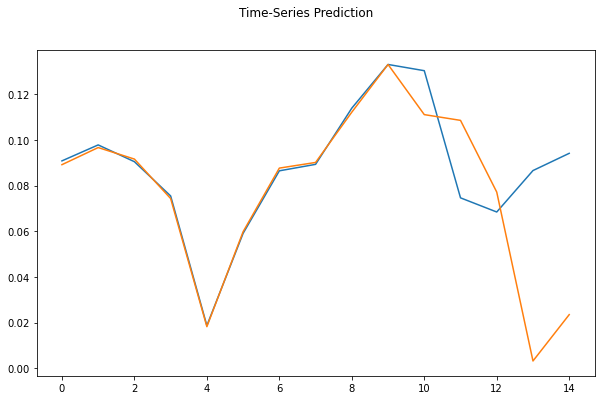

In [220]:
training_set = pd.read_csv('datasets/scaled_v3_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.04798
Epoch: 100, loss: 0.01934


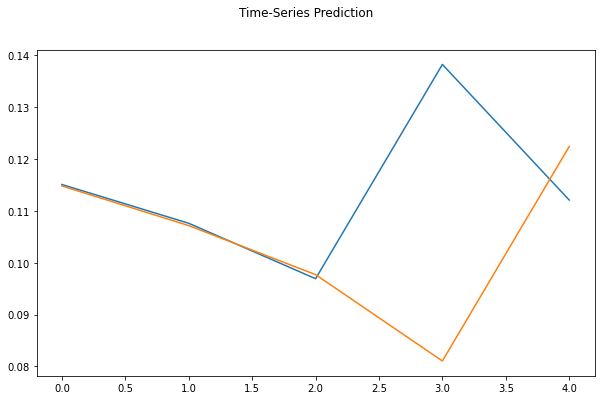

In [234]:
training_set = pd.read_csv('datasets/scaled_v3_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 150 #1000 epochs
learning_rate = 0.1#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Variogram 0.8

Epoch: 0, loss: 0.01237
Epoch: 100, loss: 0.00066
Epoch: 200, loss: 0.00063
Epoch: 300, loss: 0.00061
Epoch: 400, loss: 0.00085
Epoch: 500, loss: 0.00058
Epoch: 600, loss: 0.00054
Epoch: 700, loss: 0.00048
Epoch: 800, loss: 0.00047
Epoch: 900, loss: 0.00046
Epoch: 1000, loss: 0.00046
Epoch: 1100, loss: 0.00044
Epoch: 1200, loss: 0.00043
Epoch: 1300, loss: 0.00041
Epoch: 1400, loss: 0.00038
Epoch: 1500, loss: 0.00035
Epoch: 1600, loss: 0.00033
Epoch: 1700, loss: 0.00035
Epoch: 1800, loss: 0.00029
Epoch: 1900, loss: 0.00032


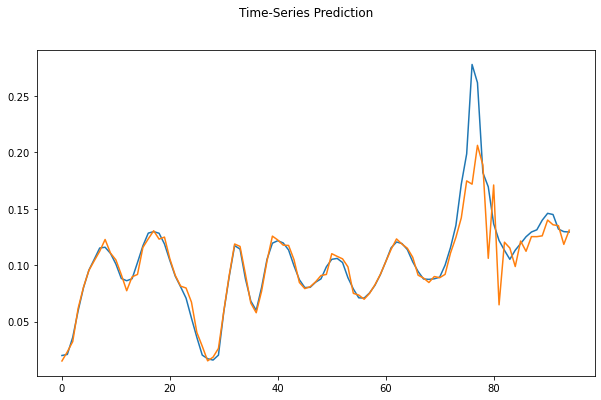

In [235]:
training_set = pd.read_csv('datasets/orig_sim4_0.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.45040
Epoch: 100, loss: 0.01251
Epoch: 200, loss: 0.00245
Epoch: 300, loss: 0.00117
Epoch: 400, loss: 0.00091
Epoch: 500, loss: 0.00076
Epoch: 600, loss: 0.00068
Epoch: 700, loss: 0.00064
Epoch: 800, loss: 0.00062
Epoch: 900, loss: 0.00062
Epoch: 1000, loss: 0.00061
Epoch: 1100, loss: 0.00060
Epoch: 1200, loss: 0.00060
Epoch: 1300, loss: 0.00060
Epoch: 1400, loss: 0.00059
Epoch: 1500, loss: 0.00059
Epoch: 1600, loss: 0.00059
Epoch: 1700, loss: 0.00059
Epoch: 1800, loss: 0.00058
Epoch: 1900, loss: 0.00058


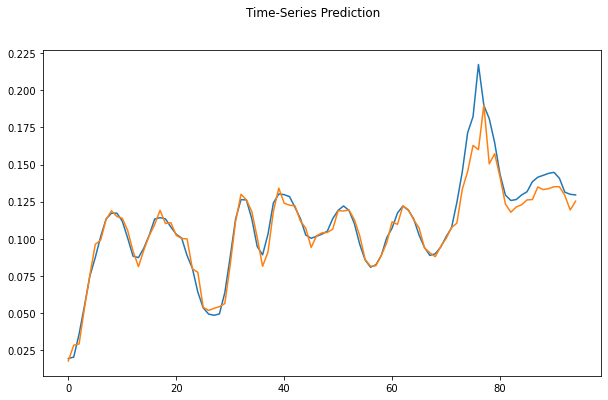

In [236]:
training_set = pd.read_csv('datasets/orig_sim4_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.21733
Epoch: 100, loss: 0.04454
Epoch: 200, loss: 0.00602
Epoch: 300, loss: 0.00250
Epoch: 400, loss: 0.00184
Epoch: 500, loss: 0.00147
Epoch: 600, loss: 0.00145
Epoch: 700, loss: 0.00144
Epoch: 800, loss: 0.00143
Epoch: 900, loss: 0.00142
Epoch: 1000, loss: 0.00142
Epoch: 1100, loss: 0.00141
Epoch: 1200, loss: 0.00140
Epoch: 1300, loss: 0.00139
Epoch: 1400, loss: 0.00138
Epoch: 1500, loss: 0.00137
Epoch: 1600, loss: 0.00135
Epoch: 1700, loss: 0.00134
Epoch: 1800, loss: 0.00135
Epoch: 1900, loss: 0.00131


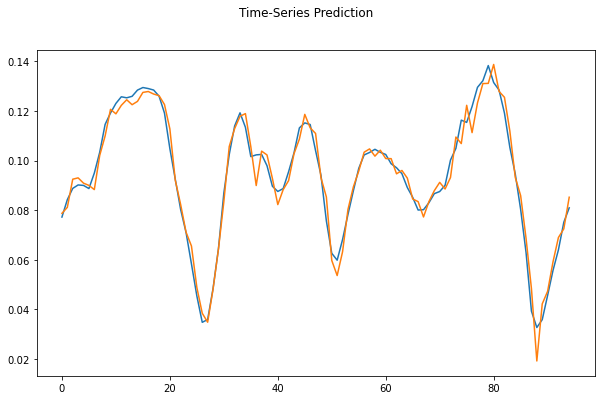

In [237]:
training_set = pd.read_csv('datasets/orig_sim4_1000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.59505
Epoch: 100, loss: 0.02423
Epoch: 200, loss: 0.00815
Epoch: 300, loss: 0.00485
Epoch: 400, loss: 0.00366
Epoch: 500, loss: 0.00304
Epoch: 600, loss: 0.00274
Epoch: 700, loss: 0.00262
Epoch: 800, loss: 0.00248
Epoch: 900, loss: 0.00195
Epoch: 1000, loss: 0.00187
Epoch: 1100, loss: 0.00183
Epoch: 1200, loss: 0.00181
Epoch: 1300, loss: 0.00179
Epoch: 1400, loss: 0.00176
Epoch: 1500, loss: 0.00172
Epoch: 1600, loss: 0.00166
Epoch: 1700, loss: 0.00160
Epoch: 1800, loss: 0.00155
Epoch: 1900, loss: 0.00152


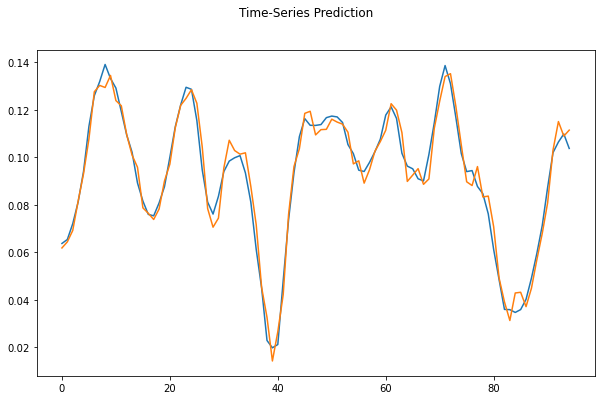

In [238]:
training_set = pd.read_csv('datasets/orig_sim4_5000.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.03039
Epoch: 100, loss: 0.00146
Epoch: 200, loss: 0.00137
Epoch: 300, loss: 0.00132
Epoch: 400, loss: 0.00126
Epoch: 500, loss: 0.00119
Epoch: 600, loss: 0.00115
Epoch: 700, loss: 0.00114
Epoch: 800, loss: 0.00113
Epoch: 900, loss: 0.00115
Epoch: 1000, loss: 0.00113
Epoch: 1100, loss: 0.00112
Epoch: 1200, loss: 0.00112
Epoch: 1300, loss: 0.00112
Epoch: 1400, loss: 0.00112
Epoch: 1500, loss: 0.00112
Epoch: 1600, loss: 0.00111
Epoch: 1700, loss: 0.00110
Epoch: 1800, loss: 0.00122
Epoch: 1900, loss: 0.00110


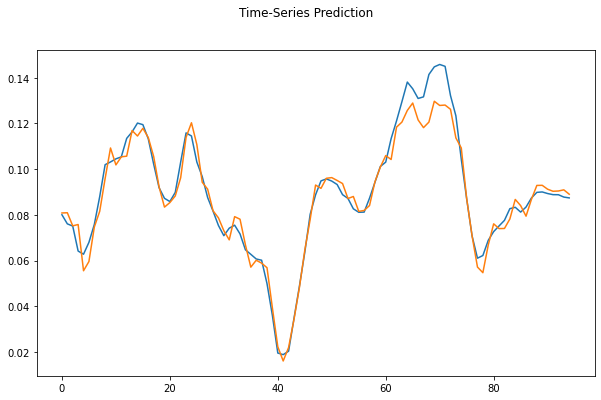

In [240]:
training_set = pd.read_csv('datasets/orig_sim4_9900.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.02527
Epoch: 100, loss: 0.00869
Epoch: 200, loss: 0.00197
Epoch: 300, loss: 0.00121
Epoch: 400, loss: 0.00090
Epoch: 500, loss: 0.00077
Epoch: 600, loss: 0.00069
Epoch: 700, loss: 0.00065
Epoch: 800, loss: 0.00062
Epoch: 900, loss: 0.00060
Epoch: 1000, loss: 0.00058
Epoch: 1100, loss: 0.00055
Epoch: 1200, loss: 0.00054
Epoch: 1300, loss: 0.00052
Epoch: 1400, loss: 0.00051
Epoch: 1500, loss: 0.00050
Epoch: 1600, loss: 0.00048
Epoch: 1700, loss: 0.00047
Epoch: 1800, loss: 0.00046
Epoch: 1900, loss: 0.00043


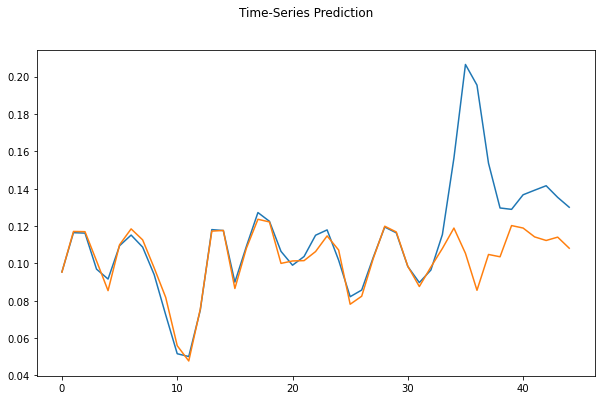

In [241]:
training_set = pd.read_csv('datasets/scaled_v4_50_100.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 1.33701
Epoch: 100, loss: 0.02808
Epoch: 200, loss: 0.01803
Epoch: 300, loss: 0.01285
Epoch: 400, loss: 0.00942
Epoch: 500, loss: 0.00814
Epoch: 600, loss: 0.00778
Epoch: 700, loss: 0.00759
Epoch: 800, loss: 0.00745
Epoch: 900, loss: 0.00734
Epoch: 1000, loss: 0.00723
Epoch: 1100, loss: 0.00711
Epoch: 1200, loss: 0.00699
Epoch: 1300, loss: 0.00684
Epoch: 1400, loss: 0.00669
Epoch: 1500, loss: 0.00655
Epoch: 1600, loss: 0.00643
Epoch: 1700, loss: 0.00630
Epoch: 1800, loss: 0.00619
Epoch: 1900, loss: 0.00607


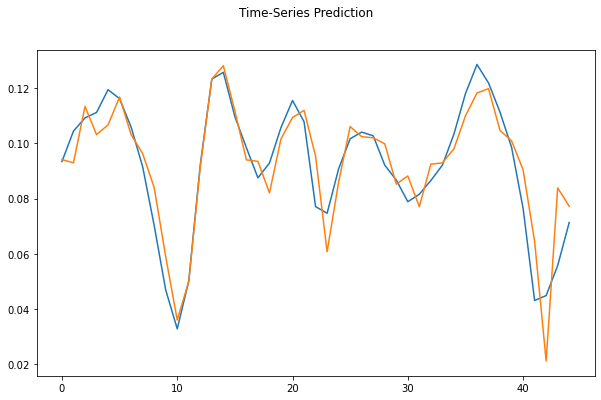

In [243]:
training_set = pd.read_csv('datasets/scaled_v4_50_115.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.14944
Epoch: 100, loss: 0.06572
Epoch: 200, loss: 0.00651
Epoch: 300, loss: 0.00413
Epoch: 400, loss: 0.00252
Epoch: 500, loss: 0.00186
Epoch: 600, loss: 0.00140
Epoch: 700, loss: 0.00121
Epoch: 800, loss: 0.00105
Epoch: 900, loss: 0.00090
Epoch: 1000, loss: 0.00112
Epoch: 1100, loss: 0.00079
Epoch: 1200, loss: 0.00086
Epoch: 1300, loss: 0.00072
Epoch: 1400, loss: 0.00070
Epoch: 1500, loss: 0.00068
Epoch: 1600, loss: 0.00067
Epoch: 1700, loss: 0.00066
Epoch: 1800, loss: 0.00066
Epoch: 1900, loss: 0.00231


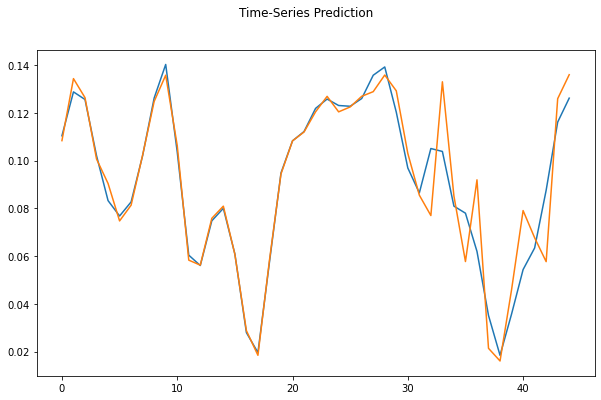

In [246]:
training_set = pd.read_csv('datasets/scaled_v4_50_515.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.06#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.91807
Epoch: 100, loss: 0.02013
Epoch: 200, loss: 0.01172
Epoch: 300, loss: 0.00955
Epoch: 400, loss: 0.00823
Epoch: 500, loss: 0.00732
Epoch: 600, loss: 0.00693
Epoch: 700, loss: 0.00674
Epoch: 800, loss: 0.00655
Epoch: 900, loss: 0.00630
Epoch: 1000, loss: 0.00600
Epoch: 1100, loss: 0.00576
Epoch: 1200, loss: 0.00564
Epoch: 1300, loss: 0.00556
Epoch: 1400, loss: 0.00546
Epoch: 1500, loss: 0.00533
Epoch: 1600, loss: 0.00522
Epoch: 1700, loss: 0.00515
Epoch: 1800, loss: 0.00511
Epoch: 1900, loss: 0.00508


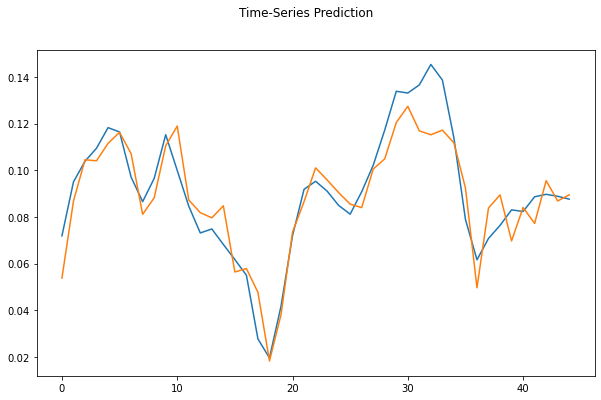

In [247]:
training_set = pd.read_csv('datasets/scaled_v4_50_999.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.18362
Epoch: 100, loss: 0.00682
Epoch: 200, loss: 0.00663
Epoch: 300, loss: 0.00626
Epoch: 400, loss: 0.00545
Epoch: 500, loss: 0.00444
Epoch: 600, loss: 0.00278
Epoch: 700, loss: 0.00233
Epoch: 800, loss: 0.00206
Epoch: 900, loss: 0.00164
Epoch: 1000, loss: 0.00118
Epoch: 1100, loss: 0.00085
Epoch: 1200, loss: 0.00058
Epoch: 1300, loss: 0.00022
Epoch: 1400, loss: 0.00011
Epoch: 1500, loss: 0.00008
Epoch: 1600, loss: 0.00006
Epoch: 1700, loss: 0.00010
Epoch: 1800, loss: 0.00005
Epoch: 1900, loss: 0.00004


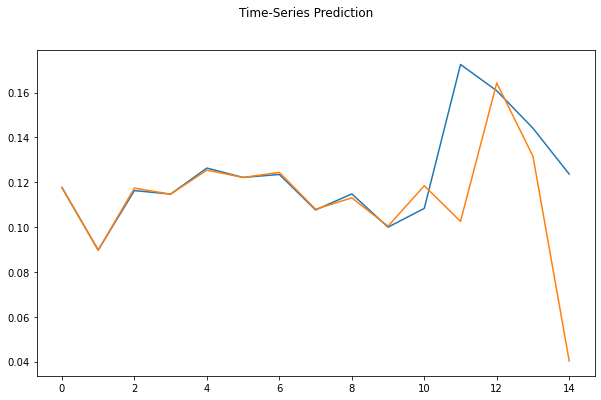

In [255]:
training_set = pd.read_csv('datasets/scaled_v4_20_300.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.09#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.02668
Epoch: 100, loss: 0.01940
Epoch: 200, loss: 0.00515
Epoch: 300, loss: 0.00339
Epoch: 400, loss: 0.00194
Epoch: 500, loss: 0.00120
Epoch: 600, loss: 0.00078
Epoch: 700, loss: 0.00066
Epoch: 800, loss: 0.00296
Epoch: 900, loss: 0.00046
Epoch: 1000, loss: 0.00026
Epoch: 1100, loss: 0.00040
Epoch: 1200, loss: 0.00027
Epoch: 1300, loss: 0.00166
Epoch: 1400, loss: 0.00027
Epoch: 1500, loss: 0.00015
Epoch: 1600, loss: 0.00070
Epoch: 1700, loss: 0.00016
Epoch: 1800, loss: 0.00006
Epoch: 1900, loss: 0.00045


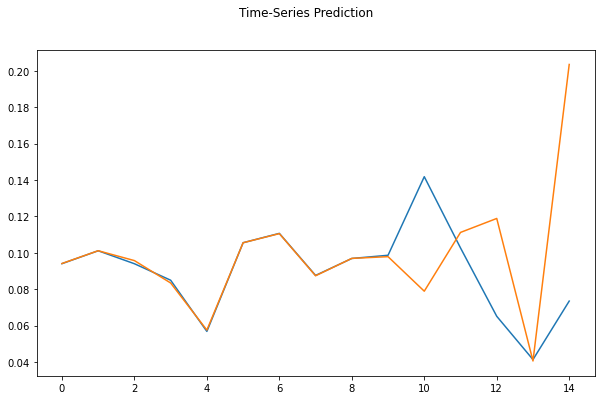

In [256]:
training_set = pd.read_csv('datasets/scaled_v4_20_490.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.23696
Epoch: 100, loss: 0.01356
Epoch: 200, loss: 0.00072
Epoch: 300, loss: 0.00036
Epoch: 400, loss: 0.00007
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00005
Epoch: 900, loss: 0.00005
Epoch: 1000, loss: 0.00010
Epoch: 1100, loss: 0.00009
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00011
Epoch: 1500, loss: 0.00007
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00011
Epoch: 1900, loss: 0.00005


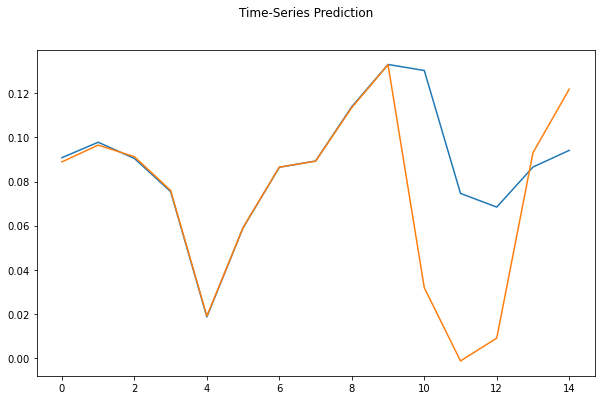

In [257]:
training_set = pd.read_csv('datasets/scaled_v4_20_980.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.31437
Epoch: 100, loss: 0.02006
Epoch: 200, loss: 0.01945
Epoch: 300, loss: 0.01833
Epoch: 400, loss: 0.01543
Epoch: 500, loss: 0.00965
Epoch: 600, loss: 0.00596
Epoch: 700, loss: 0.00099
Epoch: 800, loss: 0.00000


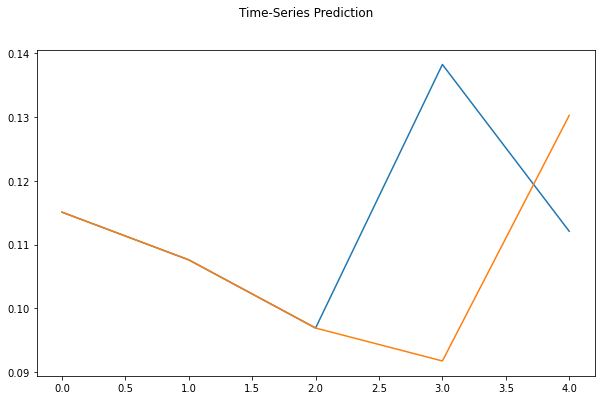

In [260]:
training_set = pd.read_csv('datasets/scaled_v4_10_700.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 900 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.72211
Epoch: 100, loss: 0.00869
Epoch: 200, loss: 0.00753
Epoch: 300, loss: 0.00620
Epoch: 400, loss: 0.00465
Epoch: 500, loss: 0.00311
Epoch: 600, loss: 0.00223
Epoch: 700, loss: 0.00167
Epoch: 800, loss: 0.00102
Epoch: 900, loss: 0.00012


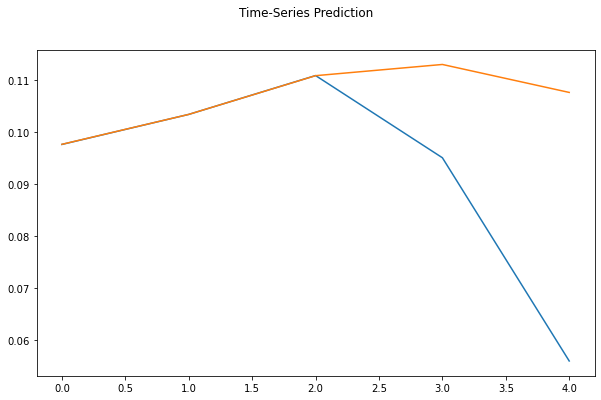

In [268]:
training_set = pd.read_csv('datasets/scaled_v4_10_495.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 1000 #1000 epochs
learning_rate = 0.01#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.6

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.24127
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000
Epoch: 1500, loss: 0.00000
Epoch: 1600, loss: 0.00000
Epoch: 1700, loss: 0.00000
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00000


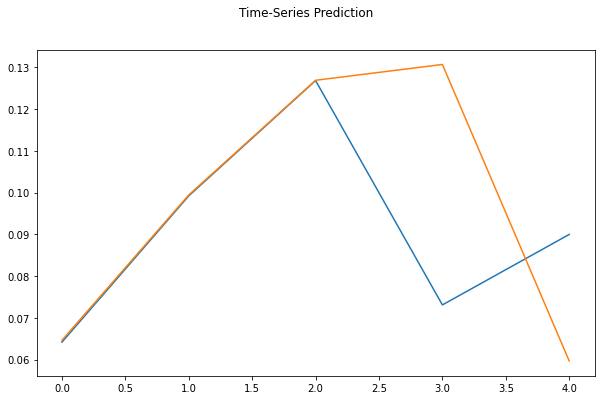

In [269]:
training_set = pd.read_csv('datasets/scaled_v4_10_970.csv')
training_set
training_set = training_set.iloc[:,2:3].values
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

num_epochs = 2000 #1000 epochs
learning_rate = 0.04#0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, p = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
loss_values = []
loss_test_values = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss_values.append(loss.item())
    # obtain the loss function
    loss = criterion(outputs, trainY)
    test_output = lstm(trainX) #forward pass
    loss_test = criterion(test_output, trainY)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(10,6))
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()